In [135]:
import os, sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

import geopandas as gp
import shapely



# Parameter

In [175]:
Daily_path='./Data/Daily_Feature/'

Load_path='./Data/Processed/'

Comparison_path='./Data/Two_strategies/'

speed=5

End_step=2

Driver_num=3000

group_num=2

# Loading the data

In [176]:
'''Location shape'''

Location_shape=gp.read_file(os.path.join(Load_path,'Location_shape.shp'))

Location_shape

'''Location list'''

Location_list=list(Location_shape['LocationID'])

Location_ID_dic=np.load(os.path.join(Load_path,'Location_ID_dic.npy')).item()

Location_ID_dic_reverse=np.load(os.path.join(Load_path,'Location_ID_dic_reverse.npy')).item()

'''Location Center'''

Location_Center_dic=np.load(os.path.join(Load_path,'Location_Center_dic.npy')).item()


'''Connection Matrix and Network distance Matrix'''

Connect_matrix=np.load(os.path.join(Load_path,'Connect_matrix.npy'))

Network_Distance=np.load(os.path.join(Load_path,'Network_Distance.npy'))

'''Geometry_dic'''

Geometry_dic=np.load(os.path.join(Load_path,'Geometry_dic.npy')).item()


'''State and Action'''

State=np.load(os.path.join(Load_path,'State.npy'))

Action=np.load(os.path.join(Load_path,'Action.npy')).item()


# Initialize Drivers

In [189]:
Driver_list=list(range(Driver_num))

Initialize_location={d:random.choice(Location_list) for d in range(Driver_num)}

# np.save('./Data/Processed/Initialize_location.npy',Initialize_location)

Driver_data=pd.DataFrame(Initialize_location.items(),columns=['Driver_id','Location_id'])

Driver_data['Order_id']=-1

Driver_data['step']=0

# Driver_data.to_csv('./Data/Processed/Driver_data.csv')

Driver_data

group_size=int(Driver_num/group_num)

group=[1 for _ in range(group_size)]+[2 for _ in range(group_size)]

random.shuffle(group)

# Driver_group={}

# for i in range(Driver_num):
    
#     Driver_group[Driver_list[i]]=group[i]
    
# np.save('./Data/Processed/Driver_group.npy',Driver_group)

Driver_group=np.load(os.path.join(Load_path,'Driver_group.npy')).item()


# Initialize Dispatch policies and Repositioning Policies

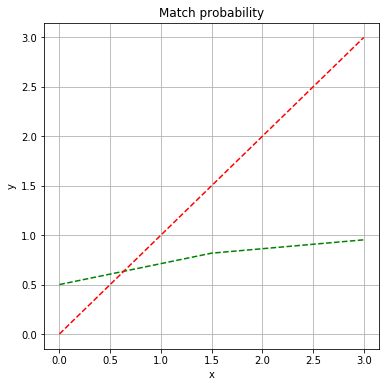

In [190]:
x = np.linspace(0,3, 3)

y1 = 1/(1+np.exp(-1*x))

y2 = x

figsize = 6,6

fig,ax = plt.subplots(figsize=figsize)
 
plt.plot(x, y1,'g--')

plt.plot(x, y2,'r--')

 
plt.title('Match probability')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
 
plt.show()


In [191]:
class Dispatch(object):
    
    def __init__(self, order_arr, driver_arr):
        self.order_arr=order_arr
        self.driver_arr=driver_arr
    
    def Get_prob(self,ratio):
        
        prob= 1/(1+np.exp(-1*ratio))
        
        if prob>ratio:
            
            return ratio
        
        else:
        
            return prob

    def random_dispatch(self):
        
        ratio=float(len(self.order_arr))/len(self.driver_arr)
        prob=self.Get_prob(ratio)
        if np.random.rand()<=prob:
            dispatched_num=int(np.ceil(prob*len(self.driver_arr)))
            dispatched_num=min(dispatched_num,len(self.order_arr))
        else:
            dispatched_num=0
        dispatched_order={};dispatched_driver={}
        
        driver_pool=random.sample(self.driver_arr,dispatched_num)
        
        for i in range(dispatched_num):
            dispatched_driver[driver_pool[i]]=self.order_arr[i]
            dispatched_order[self.order_arr[i]]=driver_pool[i]
            
        for d in self.driver_arr:
            if d not in dispatched_driver.keys():
                dispatched_driver[d]=-1
            
        for o in self.order_arr:
            if o not in dispatched_order.keys():
                dispatched_order[o]=-1
                
            
        return dispatched_driver,dispatched_order

class Reposition(object):
    
    def __init__(self, State, Action,Order_count):
        """ Load your trained model and initialize the parameters """
        self.State=State
        self.Action=Action
        self.Order_count=Order_count
        
    def random_walk(self,state):
        
        """Randomly choose the action"""
        
        return random.choice(self.Action[state])
    
    def local_hotspot(self,state):
        
        """Choose the action with maximum order count"""
        
        step=int(state.split('-')[1])
        
        action_dic={a:self.Order_count[str(a)+'-'+str(step+1)] for a in self.Action[state]}
        
        return max(action_dic, key=action_dic.get)
    
        

              
    
    

In [192]:
Request_count_dic=np.load(os.path.join(Daily_path,'Request_count_dic'+'2019-11-01'+'.npy')).item()

reposition=Reposition(State,Action,Request_count_dic)

'''Local hotspot policy sample'''
Policy_dic={}
for loc in Location_list:
    state=str(loc)+'-'+str(100)
    Policy_dic[loc]=reposition.local_hotspot(state)



# Visualization

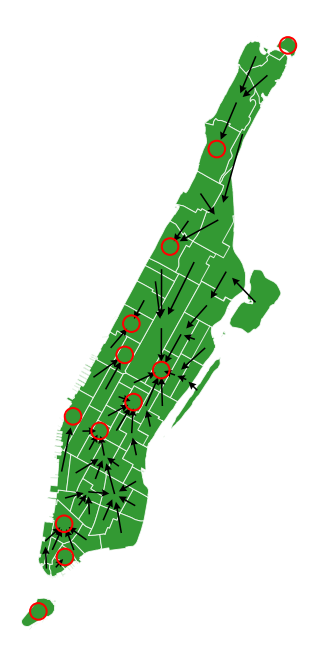

In [197]:
'''Plot the initialized coordinates of drivers'''

Sample=Driver_data.loc[Driver_data['step']==0]

Sample=Sample.groupby('Location_id').count()[['Driver_id']]

Sample['Location_id']=Sample.index

Sample=Sample.reset_index(drop=True)

Sample=Sample.rename(index=str, columns={"Driver_id": "Driver_count"})

Sample=Sample[['Location_id','Driver_count']]

Sample['weight']=0.9*(Sample['Driver_count']-min(Sample['Driver_count']))/(max(Sample['Driver_count'])-min(Sample['Driver_count']))

figsize = 8,12

fig,ax = plt.subplots(figsize=figsize)

for idx,row in Sample.iterrows():
    
    loc=row['Location_id']
    
    geometry=gp.GeoSeries(Geometry_dic[loc])

    geometry.plot(ax=ax,alpha=0.8,color='g',edgecolor='white')
    
for loc,next_loc in Policy_dic.items():
    
    X_1 =Location_Center_dic[loc][0];Y_1 =Location_Center_dic[loc][1]
    
    X_2 =X_1+0.8*(Location_Center_dic[next_loc][0]-X_1)
    
    Y_2 =Y_1+0.8*(Location_Center_dic[next_loc][1]-Y_1)
    
    U = round(X_2-X_1,5);V = round(Y_2-Y_1,5)
    
    if loc==next_loc:
    
        cir=Circle(xy = (X_1,Y_1), radius=1000, alpha=1,color = 'red',linewidth=2, fill = False)

        ax.add_patch(cir)
        
    else:
    
        plt.quiver(X_1,Y_1,U,V, angles='xy', scale_units='xy', scale=1,color='black',width=.005,headwidth=5,alpha=1,linestyle='--')
    
    
    
'''Turn off the axis'''
plt.xticks([])  
plt.yticks([])  
plt.axis('off')  


plt.show()  
    


# Simulation

In [132]:
data_str='2019-11-01'

'''Simulation'''

'''Load the Request data'''

Request_data=pd.read_csv(os.path.join(Daily_path,'Request_data'+data_str+'.csv'))

Request_data=Request_data.drop(columns=['Unnamed: 0'])

Request_data=Request_data[['Order_id','Pickup_Location','Dropoff_Location','Pickup_step','Dropoff_step','Reward_unit']]

Request_data['Dropoff_step']=Request_data.apply(lambda x:x['Dropoff_step']+1 if x['Dropoff_step']==x['Pickup_step'] else x['Dropoff_step'],axis=1)

Request_data['Driver_id']=-1

'''Load the Driver data'''

Driver_data=pd.read_csv(os.path.join(Load_path,'Driver_data.csv'))

Driver_data=Driver_data.drop(columns=['Unnamed: 0'])

Request_count_dic=np.load(os.path.join(Daily_path,'Request_count_dic'+data_str+'.npy')).item()

reposition=Reposition(State,Action,Request_count_dic)

for step in range(End_step):
    
    for location in Location_list:
    
        '''Construct the match pool: Request_arr and Driver_arr '''

        Request_arr=list(Request_data.loc[(Request_data['Pickup_step']==step)&(Request_data['Pickup_Location']==location),'Order_id'])

        Driver_arr=list(Driver_data.loc[(Driver_data['step']==step)&(Driver_data['Order_id']==-1)&(Driver_data['Location_id']==location),'Driver_id'])
        
        print(Driver_arr)
        
        if len(Driver_arr)!=0:

            dispatch=Dispatch(Request_arr,Driver_arr)

            '''Generate the matched results'''

            Matched_driver,Matched_order=dispatch.random_dispatch()

            '''Update the Request info'''

            for order_id,driver_id in Matched_order.items():

                if driver_id !=-1:

                    '''Update the matched driver info into the Request info'''

                    Request_data.loc[(Request_data['Pickup_step']==step)&(Request_data['Pickup_Location']==location)&(Request_data['Order_id']==order_id),'Driver_id']=driver_id

            '''Update the Driver info'''

            for driver_id,order_id in Matched_driver.items():

                if order_id!=-1:

                    '''Get the request info by given order_id'''

                    order_info=Request_data.loc[(Request_data['Pickup_step']==step)&(Request_data['Order_id']==order_id),['Dropoff_Location','Dropoff_step']]

                    dropoff_location=int(order_info['Dropoff_Location'])

                    dropoff_step=int(order_info['Dropoff_step'])

                    Driver_data.loc[(Driver_data['step']==step)&(Driver_data['Location_id']==location)&(Driver_data['Driver_id']==driver_id),'Order_id']=order_id

                    Driver_data=Driver_data.append({'Driver_id': driver_id,'Location_id':dropoff_location,'Order_id':-1,'step':dropoff_step}, ignore_index=True)

                else:

                    state=str(location)+'-'+str(step)

                    '''Define the reposition strategy''' 
                    
                    if step+1<End_step:

                        if Driver_group[driver_id]==1:

                            next_location=reposition.random_walk(state)

                        elif Driver_group[driver_id]==2:

                            next_location=reposition.local_hotspot(state)

                        Driver_data=Driver_data.append({'Driver_id': driver_id,'Location_id':next_location,'Order_id':-1,'step':step+1}, ignore_index=True)

# Driver_data.to_csv(os.path.join(Comparison_path,'Driver_data.csv'))

# Request_data.to_csv(os.path.join(Comparison_path,'Request_data.csv'))


# Performance

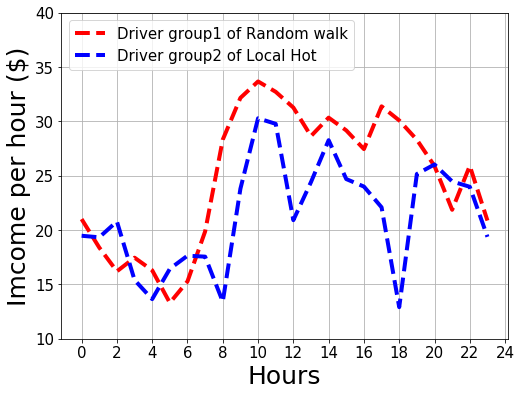

In [134]:
'''Income per minute'''

Request_data=pd.read_csv(os.path.join(Comparison_path,'Request_data.csv'))

Request_data=Request_data.drop(columns=['Unnamed: 0'])

Request_data.loc[Request_data['Driver_id']!=-1]

Driver_info=pd.DataFrame(Driver_group.items(),columns=['Driver_id','group'])

Request_data=Request_data.merge(Driver_info,on='Driver_id')

Request_data['hour']=Request_data.apply(lambda x:int(x['Pickup_step']/6),axis=1)

Income_data=Request_data.groupby(['hour','group','Driver_id']).sum()[['Reward_unit']]

Income_data['Transition']=Income_data.index

Income_data['hour']=Income_data.apply(lambda x:x['Transition'][0],axis=1)

Income_data['group']=Income_data.apply(lambda x:x['Transition'][1],axis=1)

Income_data['Driver_id']=Income_data.apply(lambda x:x['Transition'][2],axis=1)

Income_data=Income_data.reset_index(drop=True)

Income_data=Income_data[['hour','group','Driver_id','Reward_unit']]

Income_data=Income_data.groupby(['hour','group']).mean()[['Reward_unit']]

Income_data['Transition']=Income_data.index

Income_data['hour']=Income_data.apply(lambda x:x['Transition'][0],axis=1)

Income_data['group']=Income_data.apply(lambda x:x['Transition'][1],axis=1)

Income_data=Income_data.reset_index(drop=True)

Income_data=Income_data[['hour','group','Reward_unit']]

Income_data


'''Figure'''

figsize = 8,6

figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(15) for label in labels]

l1=ax1.plot(Income_data.loc[Income_data['group']==1,'hour'], Income_data.loc[Income_data['group']==1,'Reward_unit'],'r--',linewidth=4,label='Driver group1 of Random walk')

l2=ax1.plot(Income_data.loc[Income_data['group']==2,'hour'], Income_data.loc[Income_data['group']==2,'Reward_unit'],'b--',linewidth=4,label='Driver group2 of Local Hot')

ax1.set_ylabel('Imcome per hour ($)',size=25) 

ax1.set_xlabel('Hours',size=25)

ax1.set_ylim([10,40])

ax1.legend(loc = 'upper left',fontsize=15)

xmajorLocator   = MultipleLocator(2)

ax1.xaxis.set_major_locator(xmajorLocator) 


plt.grid()

plt.show()


# Diagnose

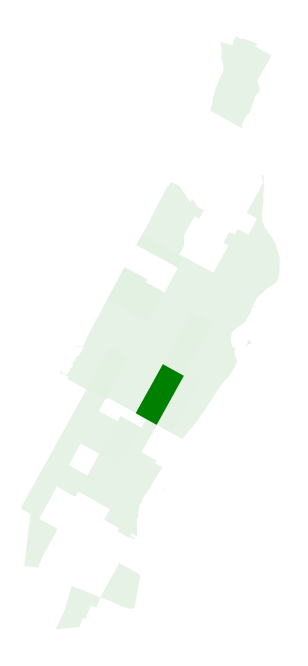

In [209]:
Driver_data=pd.read_csv(os.path.join(Comparison_path,'Driver_data.csv'))

Driver_data=Driver_data.drop(columns=['Unnamed: 0'])

Driver_data=Driver_data.loc[Driver_data['step']==90]

Driver_data=Driver_data.merge(Driver_info,on='Driver_id')

LH_Driver=Driver_data.loc[Driver_data['group']==2]

LH_Distribution=LH_Driver.groupby('Location_id').count()[['Driver_id']]

LH_Distribution['Location_id']=LH_Distribution.index

LH_Distribution['weight']=(LH_Distribution['Driver_id']-min(LH_Distribution['Driver_id']))/(max(LH_Distribution['Driver_id'])-min(LH_Distribution['Driver_id']))

LH_Distribution


figsize = 8,12

fig,ax = plt.subplots(figsize=figsize)

for idx,row in LH_Distribution.iterrows():
    
    loc=row['Location_id']
    
    geometry=gp.GeoSeries(Geometry_dic[loc])

    geometry.plot(ax=ax,alpha=0.1+0.9*row['weight'],color='g')
    
    
'''Turn off the axis'''
plt.xticks([])  
plt.yticks([])  
plt.axis('off')  


plt.show()  




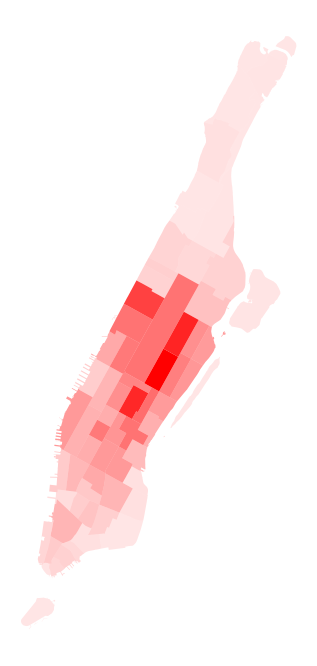

In [210]:
Local_hot={}
for loc in Location_list:
    state=str(loc)+'-'+str(90)
    Local_hot[loc]=Request_count_dic[state]
    
    
Local_hot_df=pd.DataFrame(Local_hot.items(),columns=['Location_id','Order_count'])

Local_hot_df['weight']=(Local_hot_df['Order_count']-min(Local_hot_df['Order_count']))/(max(Local_hot_df['Order_count'])-min(Local_hot_df['Order_count']))


figsize = 8,12

fig,ax = plt.subplots(figsize=figsize)

for idx,row in Local_hot_df.iterrows():
    
    loc=row['Location_id']
    
    geometry=gp.GeoSeries(Geometry_dic[loc])

    geometry.plot(ax=ax,alpha=0.1+0.9*row['weight'],color='r')
    
    
'''Turn off the axis'''
plt.xticks([])  
plt.yticks([])  
plt.axis('off')  


plt.show()  
